In [1]:
from utils import Layer, load_tweets#, process_tweet
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform

import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def train_val_split():
    # Load positive and negative tweets
    all_positive_tweets, all_negative_tweets = load_tweets()

    # View the total number of positive and negative tweets.
    print(f"The number of positive tweets: {len(all_positive_tweets)}")
    print(f"The number of negative tweets: {len(all_negative_tweets)}")

    # Split positive set into validation and training
    val_pos   = all_positive_tweets[4000:] # generating validation set for positive tweets
    train_pos  = all_positive_tweets[:4000]# generating training set for positive tweets

    # Split negative set into validation and training
    val_neg   = all_negative_tweets[4000:] # generating validation set for negative tweets
    train_neg  = all_negative_tweets[:4000] # generating training set for nagative tweets
    
    # Combine training data into one set
    train_x = train_pos + train_neg 

    # Combine validation data into one set
    val_x  = val_pos + val_neg

    # Set the labels for the training set (1 for positive, 0 for negative)
    train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))

    # Set the labels for the validation set (1 for positive, 0 for negative)
    val_y  = np.append(np.ones(len(val_pos)), np.zeros(len(val_neg)))


    return train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y

train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y = train_val_split()

print(f"length of train_x {len(train_x)}")
print(f"length of val_x {len(val_x)}")

The number of positive tweets: 5000
The number of negative tweets: 5000
length of train_x 8000
length of val_x 2000


In [3]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [4]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    '''
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    #tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
        #if word not in string.punctuation:
            # tweets_clean.append(word)
            stem_word = word #stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

process_tweet(train_x[0])

['followfriday', 'top', 'engaged', 'members', 'community', 'week', ':)']

In [5]:
# Try out function that processes tweets
print("original tweet at training position 0")
print(train_pos[0])

print("Tweet at training position 0 after processing:")
process_tweet(train_pos[0])

original tweet at training position 0
#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Tweet at training position 0 after processing:


['followfriday', 'top', 'engaged', 'members', 'community', 'week', ':)']

In [11]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m,)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        #sentence_words = X[i].lower().split()
        sentence_words = process_tweet(X[i].lower())
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j+1
            
    ### END CODE HERE ###
    
    return X_indices

X1 = np.array(["funny lol", "lets play baseball", "food is ready for you", train_x[0]],)
X1_indices = sentences_to_indices(X1, word_to_index, max_len=10)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you'
 '#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)']
X1_indices =
 [[155345. 225122.      0.      0.      0.      0.      0.      0.      0.
       0.]
 [220930. 286375.  69714.      0.      0.      0.      0.      0.      0.
       0.]
 [151204. 302254.      0.      0.      0.      0.      0.      0.      0.
       0.]
 [362050. 137337. 240688. 106074. 384714.  42869.      0.      0.      0.
       0.]]


In [13]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
      
    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        try:
            emb_matrix[idx, :] = word_to_vec_map[word]
        except:
            # "revealed" has only 40 dimension
            emb_matrix[idx, :] = np.append(word_to_vec_map[word], np.zeros(10))

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_size, emb_dim, trainable=False)
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [14]:
def sentiment_analyze(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the sentiment analyze model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units = 128, return_sequences = True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(rate=0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=64, return_sequences = False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(rate=0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(units=1)(X)
    # Add a softmax activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs= X)
    
    ### END CODE HERE ###
    
    return model

In [17]:
maxLen = len(max(train_x, key=len).split())
model = sentiment_analyze((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 28, 50)            20000050  
                                                                 
 lstm_2 (LSTM)               (None, 28, 128)           91648     
                                                                 
 dropout_2 (Dropout)         (None, 28, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65  

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [19]:
X_train_indices = sentences_to_indices(np.array(train_x + val_x), word_to_index, maxLen)
X_train_indices[0]

array([362050., 137337., 240688., 106074., 384714.,  42869.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.])

In [20]:
history = model.fit(X_train_indices, np.append(train_y, val_y), validation_split=0.2, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
250/250 [==============================] - 21s 68ms/step - loss: 0.1412 - accuracy: 0.9461 - val_loss: 0.0566 - val_accuracy: 0.9830
Epoch 2/50
250/250 [==============================] - 16s 65ms/step - loss: 0.0416 - accuracy: 0.9865 - val_loss: 0.0398 - val_accuracy: 0.9870
Epoch 3/50
250/250 [==============================] - 17s 68ms/step - loss: 0.0263 - accuracy: 0.9937 - val_loss: 0.0314 - val_accuracy: 0.9935
Epoch 4/50
250/250 [==============================] - 16s 64ms/step - loss: 0.0239 - accuracy: 0.9944 - val_loss: 0.0262 - val_accuracy: 0.9890
Epoch 5/50
250/250 [==============================] - 16s 62ms/step - loss: 0.0207 - accuracy: 0.9950 - val_loss: 0.0187 - val_accuracy: 0.9945
Epoch 6/50
250/250 [==============================] - 16s 63ms/step - loss: 0.0189 - accuracy: 0.9958 - val_loss: 0.0200 - val_accuracy: 0.9940
Epoch 7/50
250/250 [==============================] - 16s 62ms/step - loss: 0.0210 - accuracy: 0.9946 - val_loss: 0.0381 - val_accuracy:

In [21]:
X_test_indices = sentences_to_indices(np.array(val_x), word_to_index, max_len = maxLen)
loss, acc = model.evaluate(X_test_indices, val_y)
print()
print("Test accuracy = ", acc)

63/63 [==============================] - 1s 23ms/step - loss: 0.0150 - accuracy: 0.9965

Test accuracy =  0.9965000152587891


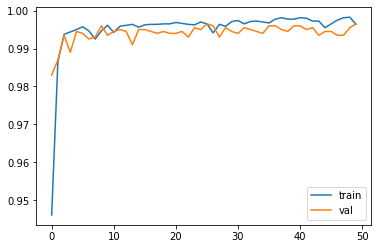

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()